Python提供了`__future__`模块，把下一个新版本的特性导入到当前版本，于是我们就可以在当前版本中测试一些新版本的特性。  
`re`是正则表达式模块  
`torch.optim`是为了更方便的更新
这个网址 https://blog.csdn.net/stupid_3/article/details/83184691 和B站李宏毅的课程讲的比较清楚

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print(device)

cuda


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {"SOS": 0, "EOS": 0, "NNNN": 0}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS and NNNN

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10
MAX_LEN = 12

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def standardizeSeq(s):
    return "SOS " + s + " EOS"

def filterPairs(pairs):
    #这个是前面不补SOS，后面不补EOS，也不补助的情况。
    #return [pair for pair in pairs if filterPair(pair)]
    #这个是补了SOS，EOS，且长度补齐的情况
    return [(standardizeSeq(pair[0]), standardizeSeq(pair[1])) for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
('SOS c est lui n est ce pas ? EOS', 'SOS he s the one isn t he ? EOS')


各个变量的维度：（这个和下面的矩阵横竖是一样的，第一维是横，一般输入也是第一维是长度嘛，然后竖着表示特征数）  
input: len \* input_size(特征数）  
output: len \* input_size(特征数)  
matq: len \* hidden_size  
matv: 同上  
matk: 同上  
scale:  那个就是指 $\sqrt{output\_size}$ ，除以就是减小结果  
然后是我的代码中的:  
attention: 与论文中的不一样，就是q,v产生的，len \* len  
mattv: 这个是论文中的attention, len \* hidden_size  
y: len \* input_size
首先我们要明白self-attention是什么，其实它输入输出和RNN是一样的，就是用于替换RNN层  
各个变量的现实意义：  
个人理解：q表示询问，可以理解当前这个元素的信息，而k则是key，可以理解为询问对这个问题产生的关注是多少，将这个元素和某个元素组合，得到attention，v则是值，表示当前元素的值，用于经过这样的attention,最后产生的影响
![avatar](self-attention1.jpg)
然后我们可以把向量叠成matrix来简化运算,其中q,k,v都是input通过矩阵乘法产生的
![avatar](matrix1.jpg) ![avatar](matrix2.jpg)
首先理解scaledDotProductAttention是在干什么：  
![avatar](scaled_dot-product_attention.jpg)  
scaledDotAttention就是在干这个，之所以可以写成矩阵乘法就是如同上面的那个图，下面贴一个完整的图：
![avatar](sdpa.jpg)
其中的那个scale就是前面说的除以减小结果的意思  
而mask就是为了不再不必要的地方产生attention，比如为了使句子长度相同而后补的0，比如在decoder时输出时不应看到未来的，例如现在在句中的位置t，
就应仅与句子中的t-1前的内容产生attention。而mask的方法就是在那些位置填-inf,这样softmax后就变成0了。下面的`tensor.mask_fill_(bool_matrix,value)`  
下面是multiheadAttention  
![avatar](mha.jpg)
concat就是把几个head拼接起来，h是head的数量

注意linear是这样瞎搞的，它的输入也是第一维是长度，和前面是对应的，中间随你放多少维，反正最后一维是特征数
![avatar](linear.jpg)

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_size, hidden_size, head = 2):
        super(MultiHeadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_dim = hidden_size // head
        self.input_size = input_size
        self.head = head
        
        self.qlinear = nn.Linear(input_size,hidden_size)
        self.vlinear = nn.Linear(input_size,hidden_size)
        self.klinear = nn.Linear(input_size,hidden_size)
        self.ylinear = nn.Linear(hidden_size,input_size)
        
    def scaledDotProductAttention(self, matq, matk, matv, mask):
        scale = matk.size(-1)**0.5
        matt = matq.matmul(matk.transpose(1,2))/scale  #(head, N, hidden_dim) * (head, hidden_dim, N) -> (head, N, N)
        if not mask is None:
            matt.masked_fill_(mask, -np.inf)
        matt = F.softmax(matt, dim=-1)  #(head, N, N) * (head, N, hidde_dim)
        mattv = matt.matmul(matv)
        return torch.cat(torch.chunk(mattv.view(-1,self.hidden_dim), self.head,0), dim = 1) #(head, N, hidden_dim) ->(N, hidden_size)
    
    def toMulti(self, matx):#这里是把特征等分
        return torch.cat(torch.chunk(matx, self.head, -1),dim=0).view(self.head, -1, self.hidden_dim)
    
    def forward(self, inputq, inputk, inputv, mask = None):
        matq = self.toMulti(self.qlinear(inputq))
        matv = self.toMulti(self.vlinear(inputv))
        matk = self.toMulti(self.klinear(inputk))
        mattv = self.scaledDotProductAttention(matq, matk, matv, mask)
        y = self.ylinear(mattv)
        return y

In [11]:
def sequece_mask(input):
    len = input.size(-2)
    return torch.triu(torch.ones((len,len), dtype = torch.bool), diagonal = 1).to(device)
    #里面ones和zeros差不多，就是产生1； dtype之所以用这个是因为mask需要为bool
    #而triu函数则是将参数一的上三角部分返回回去，剩下的补0，而diagonal决定了是否多返回或少返回，看下面这张图

![avatar](triu.jpg)

In [12]:
#开始检查没有mask的对不对
model1 = MultiHeadAttention(5, 2).to(device)
input1 = torch.randn(6,5).to(device)
y1= model1(input1,input1,input1)
print(y1)
torch.sum(y1).backward()

tensor([[-0.9800,  0.9045,  0.5975,  0.2966,  0.8535],
        [-1.1063,  1.0337,  0.5560,  0.4519,  0.9150],
        [-1.0342,  0.9600,  0.5809,  0.3624,  0.8811],
        [-0.9960,  0.9172,  0.5353,  0.3530,  0.8082],
        [-0.7773,  0.7095,  0.8539, -0.0749,  0.9318],
        [-1.0151,  0.9433,  0.6298,  0.3115,  0.9115]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [13]:
#开始检查有mask的对不对
model1 = MultiHeadAttention(5, 2).to(device)
input1 = torch.randn(6,5).to(device)
y1 = model1(input1,input1,input1,sequece_mask(input1))
print(y1)
torch.sum(y1).backward()

tensor([[-0.1460, -0.8055,  0.5507, -0.5601, -0.3235],
        [-0.2116, -0.8053,  0.6204, -0.6045, -0.5233],
        [-0.1544, -0.9438,  0.5728, -0.6413, -0.2945],
        [-0.0503, -0.8133,  0.4497, -0.4995, -0.0290],
        [-0.0012, -0.8401,  0.4000, -0.4808,  0.1312],
        [ 0.0013, -0.7856,  0.3921, -0.4493,  0.1174]], device='cuda:0',
       grad_fn=<AddmmBackward>)


位置编码，讲解见后，这里仅给出公式以及这个公式为什么可行：
$$PE_{(pos,2*i)} = sin(pos/{10000^{2i/d_{model}}})$$
$$PE_{(pos,2*i+1)} = cos(pos/{10000^{2i/d_{model}}})$$
这所以可行，是因为这不仅可以表示绝对位置，也可以表示相对位置，$sin(x+y)=sin(x)cos(y)+cos(x)sin(y)$，这意味着$PE(pos+k)$可以用$PE(pos)$和$PE(k)$来表示，故可以表示相对位置

In [14]:
class PositionEncoding(nn.Module):
    def __init__(self, max_len, word_size):
        super(PositionEncoding, self).__init__()
        self.position_mat = torch.tensor([[pos/np.power(10000,i//2*2/word_size) for i in range(word_size)] for pos in range(max_len)], \
                                        dtype = torch.float32).to(device)
        self.position_mat[:,0::2] = torch.sin(self.position_mat[:,0::2])
        self.position_mat[:,1::2] = torch.cos(self.position_mat[:,1::2])
    
    def forward(self, input):
        return input + self.position_mat[0:input.size(-2),0:input.size(-1)]

![avatar](transformer.jpg)
embedded: len \* word_size 这里面需要考虑位置的影响，不然之前那样不考虑位置是不科学的，这个就是有一种奇特的方法加上一个向量。为什么是加呢？
可以这样理解：把原来的input延长，补一个位置one-hot变量，那么乘一个矩阵压到这么多维，可以相等于加一个矩阵。embedding的格式
就是把input的每个元素都扩展成word_size维的向量，它的两个重要参数第一个是字典大小，第二个是word_size。后面那个参数padding_idx=0表示遇到这个数时生成全为0的向量，比如你输入为了补齐，补了一些0(这份代码补的是2)，这些啥用都没有，就直接生成全0就好了
output: len \* word_size  
output2: len \* word_size  
图中每一个的意义： 
n:首先这个是进行了多次，原论文是6次，本次本着性能不足的原因，就进行一次，若要多次，可把这个封装成一个类，在encodertran调多次即可。  
add:就是input+output，加的目的是使梯度>1，防止梯度消失   
norm:就是layernormalization  
feed forward:就是一个最普通前馈式神经网络，为什么要接这个我也不明白。网上有大佬说接这个是为了使更有效（expressiveness，不知道咋翻译），理由是
前面的都是线性的，而这个可以带来了一些非线性的混合。

normalization归一化：使数据的均值和方差变成指定的数，方便学习。
![avatar](layernorm.jpg)
那个E是均值的意思，Var是方差的意思，$\gamma$是新的方差，$\beta$是新的均值  
layerNormalization就是把一个数据自身的所有特征进行normalization，而batchNormalization就是把一个batch的所有数据的同一个特征拿来normalization  
至于为什么要有$\gamma$$\beta$，网上大佬的解释是使他具有capacity，比如如果你后接了一个ReLU,没这个的话一半的输入都输出0，就太不合理了。

In [15]:
class EncoderTran(nn.Module):
    #word_number是指字典大小，word_size是embedding的产生出来的size,hidden_size就是multiheadAttention中的hidden_size
    #ff_size就是那个前馈式神经网络的隐藏层，max_len就是句子的最长长度，是用来处理位置向量的
    def __init__(self, word_number, word_size = 256, hidden_size = 380, ff_size = 400, max_len = MAX_LEN):
        super(EncoderTran, self).__init__()
        self.word_size = word_size
        self.hidden_size = hidden_size
        self.ff_size = ff_size
        self.max_len = max_len
        
        self.embedding = nn.Embedding(word_number, word_size)
        self.position_mat = PositionEncoding(max_len, word_size)
        self.multi_head_attention = MultiHeadAttention(word_size,hidden_size)
        self.layernorm1 = nn.LayerNorm(word_size)#里面直接填特征数就可以了，输入len * 特征数就可以了
        self.ffn_linear1 = nn.Linear(word_size, ff_size)
        self.ffn_linear2 = nn.Linear(ff_size,word_size)
        self.layernorm2 = nn.LayerNorm(word_size)
    
    def forward(self, input):
        embedded =  self.position_mat(self.embedding(input))
        #这个mask会自动广播，可以结合图看，只需要使得attention矩阵涉及0的竖行为0就可以了，
        #因为横行一是不影响，aij才表示j位置对i位置的attention,只要使添0的地方对有内容的不影响就行了
        #二是反正softmax前都全为0，即使写出了-inf一是一样的
        output = self.multi_head_attention(embedded, embedded, embedded)
        output = self.layernorm1(output + embedded)
        output2 = self.ffn_linear2(F.relu(self.ffn_linear1(output)))
        output2 = self.layernorm2(output2+output)
        return output2

In [16]:
#开始检查对不对
model1 = EncoderTran(10, 5, 4, 3, 9).to(device)#小细节，测试的时候不要让维度有相同的数，这样可以检查维度正不正确
input1 = torch.tensor([1,2,7,8,0,9,7,2]).to(device)
y1 = model1(input1)
print(y1)
torch.sum(y1).backward()

tensor([[-0.5822,  1.5830, -1.2447, -0.4147,  0.6586],
        [ 1.1806,  0.3597, -0.0047,  0.3041, -1.8397],
        [-0.6398, -0.9151, -0.0357,  1.9104, -0.3198],
        [-1.1772, -0.7396,  1.6711,  0.4723, -0.2266],
        [ 0.4121,  0.4745,  0.2042, -1.9540,  0.8632],
        [-1.0488,  1.6597, -0.0704,  0.4349, -0.9753],
        [-1.5248,  0.2272, -0.0185,  1.5953, -0.2793],
        [ 0.9337,  0.5870,  0.1316,  0.2696, -1.9219]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward>)


注意：此处，我们让输出和输入长度在训练时都是相同的，方便以后改成可以不一个一个输入，一个batch一个batch输入的情况，在第二个attention(即encoder-decoder attention）那里，注意维度，下面用1指代input，2用来output指代翻译出来的句子。  
matq: len2 \* word_size  
matk: len1 \* word_size  
matv: len1 \* word_size  
attention: len2 \* len1  
output2: len2 \* word_size  
此处已经不需要mask了

In [17]:
class DecoderTran(nn.Module):
    def __init__(self,  word_number, word_size = 256, hidden_size = 380, ff_size = 400, max_len = MAX_LEN):
        super(DecoderTran, self).__init__()
        self.word_size = word_size
        self.hidden_size = hidden_size
        self.ff_size = ff_size
        self.max_len = max_len
        
        self.embedding = nn.Embedding(word_number, word_size)
        self.position_mat = PositionEncoding(max_len, word_size)
        
        self.multi_head_attention1 = MultiHeadAttention(word_size,hidden_size)
        self.layernorm1 = nn.LayerNorm(word_size)
        
        self.multi_head_attention2 = MultiHeadAttention(word_size,hidden_size)#调用这个的时候确实padding_mask想不清楚，不管了
        self.layernorm2 = nn.LayerNorm(word_size)
        
        self.ffn_linear1 = nn.Linear(word_size, ff_size)
        self.ffn_linear2 = nn.Linear(ff_size,word_size)
        self.layernorm2 = nn.LayerNorm(word_size)
        
        self.ans_linear = nn.Linear(word_size,word_number)
    
    def forward(self, input, enc_output):
        embedded =  self.position_mat(self.embedding(input))
        output = self.multi_head_attention1(embedded, embedded, embedded, sequece_mask(embedded))
        output = self.layernorm1(output + embedded)
        
        output2 = self.multi_head_attention2(output, enc_output, enc_output)#注意顺序
        output2 = self.layernorm2(output2 + output)
        
        output3 = self.ffn_linear2(F.relu(self.ffn_linear1(output2)))
        output3 = self.layernorm2(output3+output2)
        
        output4 = F.log_softmax(self.ans_linear(output3),dim=1)
        return output4

In [18]:
#开始检查对不对
model1 = EncoderTran(10, 5, 4, 3, 9).to(device)#小细节，测试的时候不要让维度有相同的数，这样可以检查维度正不正确
input1 = torch.tensor([1,2,7,8,3,9,7,2,0]).to(device)
y1 = model1(input1)

model2 = DecoderTran(10, 5, 4, 3, 9).to(device)
input2 = torch.tensor([3,5,7,8,3]).to(device)
y2 = model2(input2, y1)
print(y2)
torch.sum(y1).backward()

tensor([[-1.3830, -1.8019, -2.7140, -2.1421, -2.6841, -2.7553, -2.6352, -2.9539,
         -2.4179, -2.8876],
        [-2.0390, -2.5321, -3.3031, -1.3637, -2.7269, -2.0568, -2.0302, -3.0295,
         -2.3025, -3.6913],
        [-2.7550, -3.1896, -2.8502, -1.2424, -2.5871, -1.8859, -2.6350, -2.4086,
         -2.2358, -2.9343],
        [-2.5563, -2.8003, -3.0144, -1.1578, -2.8635, -1.8502, -2.6806, -2.5780,
         -2.3544, -3.1081],
        [-1.7409, -2.0272, -2.7732, -1.5226, -2.7958, -2.5577, -2.8762, -2.8092,
         -2.5032, -2.5856]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token),前面添加了
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)#这里把它变成了一个向量

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
#测试：
print(input_lang.word2index["SOS"])
pair=random.choice(pairs)
print(pair)
print(tensorsFromPair(pair))
pair=random.choice(pairs)
print(pair)
print(tensorsFromPair(pair))

0
('SOS vous abusez de votre autorite . EOS', 'SOS you are abusing your authority . EOS')
(tensor([   0,  118, 3859,  101,  645, 3404,    5,    1], device='cuda:0'), tensor([   0,  129,  124, 2415,  350, 2093,    4,    1], device='cuda:0'))
('SOS vous n etes pas censee nager ici . EOS', 'SOS you aren t supposed to swim here . EOS')
(tensor([   0,  118,  245,  214,  246, 4028, 1409,   64,    5,    1],
       device='cuda:0'), tensor([   0,  129,  564,  538, 1942,  532,  762,   46,    4,    1],
       device='cuda:0'))


In [21]:
#这个函数每次是在拿一个句子进行训练，句子在之前已经补足
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    #清空梯度
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = encoder(input_tensor)
    
    decoder_outputs = decoder(target_tensor, encoder_outputs)
    loss = criterion(decoder_outputs[0:-1], target_tensor[1:])
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [22]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m,s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [23]:
#这里才是总的训练
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0].to(device)
        target_tensor = training_pair[1].to(device)
        
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [24]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

cuda
0m 23s (- 3m 27s) (1000 10%) 0.4236
0m 47s (- 3m 10s) (2000 20%) 0.3442
1m 12s (- 2m 49s) (3000 30%) 0.3241
1m 37s (- 2m 26s) (4000 40%) 0.3054
2m 2s (- 2m 2s) (5000 50%) 0.2961
2m 27s (- 1m 38s) (6000 60%) 0.2824
2m 53s (- 1m 14s) (7000 70%) 0.2707
3m 18s (- 0m 49s) (8000 80%) 0.2609
3m 44s (- 0m 24s) (9000 90%) 0.2546
4m 9s (- 0m 0s) (10000 100%) 0.2461


<Figure size 432x288 with 0 Axes>

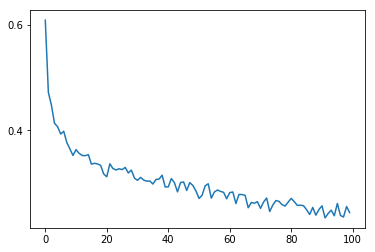

In [25]:
print(device)
encoder1 = EncoderTran(input_lang.n_words).to(device)
decoder1 = DecoderTran(output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 10000, print_every=1000)

0m 36s (- 59m 39s) (1000 1%) 0.2388
0m 57s (- 47m 11s) (2000 2%) 0.2302
1m 18s (- 42m 29s) (3000 3%) 0.2213
1m 39s (- 39m 59s) (4000 4%) 0.2170
2m 1s (- 38m 26s) (5000 5%) 0.2070
2m 22s (- 37m 19s) (6000 6%) 0.2061
2m 44s (- 36m 22s) (7000 7%) 0.2036
3m 6s (- 35m 42s) (8000 8%) 0.1929
3m 27s (- 35m 2s) (9000 9%) 0.1930
3m 49s (- 34m 21s) (10000 10%) 0.1810
4m 10s (- 33m 46s) (11000 11%) 0.1832
4m 32s (- 33m 15s) (12000 12%) 0.1730
4m 53s (- 32m 45s) (13000 13%) 0.1730
5m 14s (- 32m 14s) (14000 14%) 0.1721
5m 36s (- 31m 46s) (15000 15%) 0.1649
5m 58s (- 31m 19s) (16000 16%) 0.1536
6m 19s (- 30m 52s) (17000 17%) 0.1534
6m 40s (- 30m 26s) (18000 18%) 0.1487
7m 2s (- 29m 59s) (19000 19%) 0.1424
7m 23s (- 29m 33s) (20000 20%) 0.1413
7m 44s (- 29m 9s) (21000 21%) 0.1435
8m 6s (- 28m 44s) (22000 22%) 0.1390
8m 27s (- 28m 19s) (23000 23%) 0.1321
8m 49s (- 27m 56s) (24000 24%) 0.1327
9m 11s (- 27m 33s) (25000 25%) 0.1288
9m 32s (- 27m 9s) (26000 26%) 0.1201
9m 54s (- 26m 48s) (27000 27%) 0.1204

<Figure size 432x288 with 0 Axes>

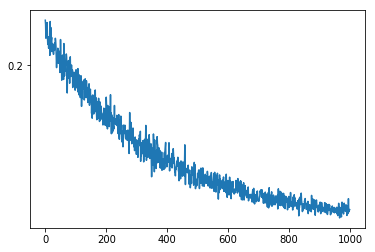

In [79]:
trainIters(encoder1, decoder1, 100000, print_every=1000)

In [26]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LEN):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_outputs = encoder(input_tensor)
    
        decoder_input = torch.tensor([0], device = device)
        
        decoded_words = []
        
        for di in range(max_length):
            decoder_output = decoder(decoder_input, encoder_outputs)
            topv, topi = decoder_output[di].data.topk(1)
            #print(decoder_output[di])
            #print(topv)
            #print(topi)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = torch.cat((decoder_input, torch.tensor([topi.item()], device = device)))
            
        return decoded_words

In [27]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [28]:
evaluateRandomly(encoder1, decoder1)

> SOS elle est un tres bon professeur . EOS
= SOS she is a very good teacher . EOS
< she is a very good at you . <EOS>

> SOS je suis de votre cote . EOS
= SOS i m by your side . EOS
< i m your friend . <EOS>

> SOS je suis satisfaite de sa performance . EOS
= SOS i m pleased with his performance . EOS
< i m sure of his . <EOS>

> SOS je vieillis . EOS
= SOS i m getting old . EOS
< i m surprised . <EOS>

> SOS ils mettent le paquet . EOS
= SOS they are investing a lot . EOS
< they re the same . <EOS>

> SOS nous en sommes toutes d accord . EOS
= SOS we re all agreed on that . EOS
< we re all alone . <EOS>

> SOS tu es voyant . EOS
= SOS you re psychic . EOS
< you re doing . <EOS>

> SOS vous allez perdre . EOS
= SOS you re going to lose . EOS
< you re resilient . <EOS>

> SOS je suis sure que nous pouvons arranger cela . EOS
= SOS i m sure we can work this out . EOS
< i m glad i am as you . <EOS>

> SOS il est joueur . EOS
= SOS he s a gambler . EOS
< he is about to go . <EOS>

